# ASSIST: publication figures

Here we regenerate the figures for the ASSIST publication one place.  This allows ASSIST users to see exactly how those figures were made.

This notebook assumes that you have install ASSIST and the ephemeris files. If you are unfamiliar with ASSIST, we suggest that you first look at the "Getting started" notebook.

First, let's import REBOUND, ASSIST as well as numpy and matplotlib.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import assist 
au2m = 149597870700
au_km = au2m/1000.

Next, we create an ephemeris structure. ASSIST will use this structure to access the JPL Ephemeris files during the integrations. Depending on where you have stored the files, you might need to adjust the paths.

In [2]:
ephem = assist.Ephem("../data/linux_p1550p2650.440", "../data/sb441-n16.bsp")

### Simple Figure

In [3]:
sim = rebound.Simulation()
holman_initial = rebound.Particle(
    x=3.338875348598862E+00, y=-9.176518412197102E-01, z=-5.038590741719294E-01, 
    vx=2.805663364339457E-03, vy=7.550408665778840E-03, vz=2.980028207875623E-03)
sim.add(holman_initial)

scale=1e-8
sim.add(holman_initial + rebound.Particle(x=scale))
sim.add(holman_initial + rebound.Particle(y=scale))
sim.add(holman_initial + rebound.Particle(z=scale))
sim.add(holman_initial + rebound.Particle(vx=scale))
sim.add(holman_initial + rebound.Particle(vy=scale))
sim.add(holman_initial + rebound.Particle(vz=scale))

ex = assist.Extras(sim, ephem)

In [4]:
var = sim.add_variation(testparticle=0)
var.particles[0].x = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].y = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].z = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vx = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vy = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vz = 1.0

In [5]:
trange = 10_000
N = 500 # number of outputs
times = np.linspace(sim.t, sim.t+trange, N)

pos_holman = np.zeros((N,7,3))
pos_holman_per = np.zeros((N,6,3))
pos_holman_var = np.zeros((N,6,3))

for i in range(N):
    ex.integrate_or_interpolate(times[i])
    for j in range(7):
        pos_holman[i,j] = sim.particles[j].xyz
    for j in range(6):
        pos_holman_var[i,j] = sim.particles[7+j].xyz

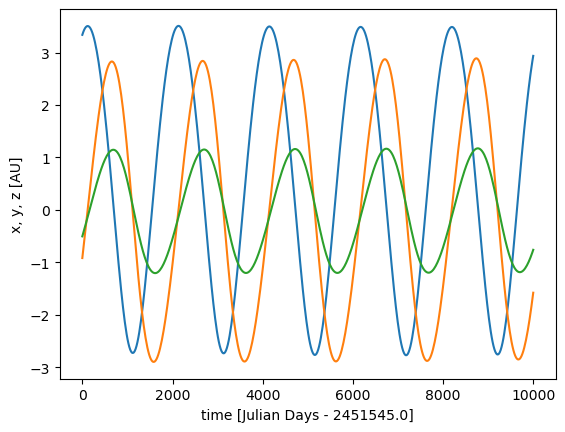

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("time [Julian Days - %.1f]"%ephem.jd_ref)
ax.set_ylabel("x, y, z [AU]")
ax.plot(times, pos_holman[:,0,:]);

### Figure 1.

Text(0, 0.5, 'AU')

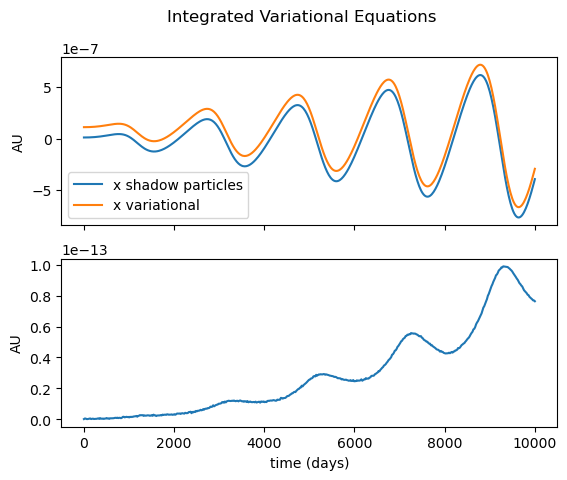

In [7]:
scale=1e-8
fig, axs = plt.subplots(2)
fig.suptitle('Integrated Variational Equations')

axs[0].plot(times, (pos_holman[:,1,:]-pos_holman[:,0,:])[:,0], label='x shadow particles')
axs[0].plot(times, pos_holman_var[:,0,0]*scale+1e-7, label='x variational')
axs[0].set_ylabel("AU")
axs[0].legend()
axs[0].label_outer()

axs[1].plot(times, np.linalg.norm((pos_holman[:,1,:]-pos_holman[:,0,:]-pos_holman_var[:,0,:]*scale), axis=1))
axs[1].set_xlabel("time (days)")
axs[1].set_ylabel("AU")
#plt.savefig('numerical_vs_analytic_2panel.pdf')

In [8]:
ex.detach(sim)
del(sim)

### Figure 2.

In [9]:
def round_trip(trange):
    sim = rebound.Simulation()
    t0 = 2458849.5-ephem.jd_ref;
    x0=3.338875348598862E+00
    y0=-9.176518412197102E-01
    z0=-5.038590741719294E-01
    vx0=2.805663364339457E-03
    vy0=7.550408665778840E-03
    vz0=2.980028207875623E-03
    holman_initial = rebound.Particle(x=x0, y=y0, z=z0, vx=vx0, vy=vy0, vz=vz0)
    sim.add(holman_initial)
    ex = assist.Extras(sim, ephem)
    
    sim.t=t0
    sim.dt=20
    sim.integrate(t0+trange)
    
    sim.dt *=-1
    sim.integrate(t0)
    
    d = np.linalg.norm((sim.particles[0]-holman_initial).xyz)*au2m
    
    ex.detach(sim)
    del(sim)
    
    return(d)

In [10]:
results=[]
for trange in np.logspace(0, 5, num=30):
    results.append((trange, round_trip(trange)))

In [11]:
t = np.array(list(map(lambda x: x[0], results)))
dx = list(map(lambda x: x[1], results))

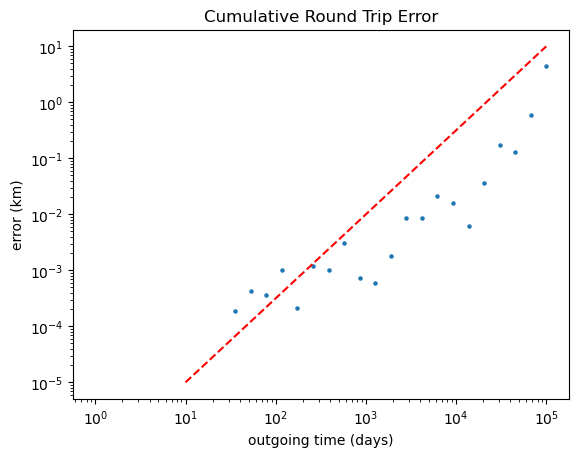

In [12]:
plt.scatter(t[:], dx[:], s=5)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('outgoing time (days)')
plt.ylabel('error (km)')
plt.title('Cumulative Round Trip Error')
plt.plot((1e1,1e5), (1e-5,1e+1), '--', c='r')
#plt.savefig('roundtrip_Holman.pdf')

In [13]:
t_initial = 2.4621385359989386E+06 - ephem.jd_ref # Julian Days relative to jd_ref

apophis_initial_helio = rebound.Particle(x = -5.5946538550488512E-01, # AU
                                         y =  8.5647564757574512E-01, 
                                         z =  3.0415066217102493E-01,
                                         vx= -1.3818324735921638E-02, # AU/day
                                         vy= -6.0088275597939191E-03, 
                                         vz= -2.5805044631309632E-03)

sun_initial = ephem.get_particle("sun", t_initial)

# convert from heliocentric to barycentric coordinates
apophis_initial = apophis_initial_helio + sun_initial 

In [14]:
sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = t_initial 
sim.dt = 1.0
sim.ri_ias15.min_dt = 0.001
ex = assist.Extras(sim, ephem)
ex.particle_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.0])

In [15]:

t_final = 2.4625030372426095E+06  - ephem.jd_ref
times = []
dts = []
while(sim.t < t_final):
    times.append(sim.t)
    sim.step()
    dts.append(sim.dt_last_done)

times=np.array(times)
dts=np.array(dts)

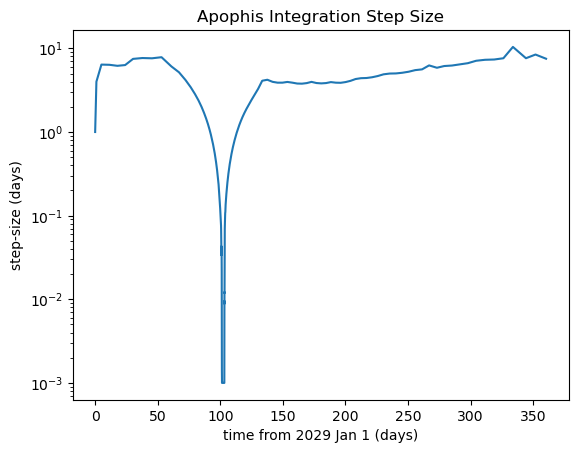

In [16]:

fig, ax = plt.subplots()
#ax.set_aspect("equal")
ax.plot(times-times[0], dts)
ax.set_title('Apophis Integration Step Size')
ax.set_xlabel("time from 2029 Jan 1 (days)")
ax.set_ylabel("step-size (days)")
ax.set_yscale('log')

#plt.xlim(0,110)
#plt.savefig('apophis_step_size.pdf')
#plt.xlim(0,110)

In [17]:
ex.detach(sim)
del(sim)

In [18]:
sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = t_initial 
sim.dt = 1.0
sim.ri_ias15.min_dt = 0.001
ex = assist.Extras(sim, ephem)
ex.particle_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.0])

In [19]:
t_final = 2.4625030372426095E+06  - ephem.jd_ref
N_samples = 10000
times = np.linspace(t_initial, t_final, N_samples, endpoint=True)
apophis_pos = np.zeros((N_samples, 3))
earth_pos = np.zeros((N_samples, 3))
for i, t in enumerate(times):
    ex.integrate_or_interpolate(t)
    apophis_pos[i] = sim.particles[0].xyz
    earth_pos[i] = ephem.get_particle("earth", t).xyz

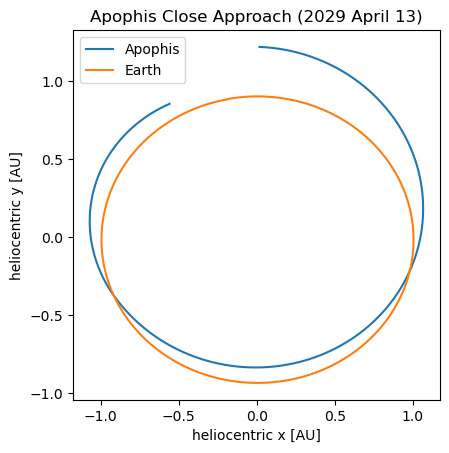

In [20]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("heliocentric x [AU]"); ax.set_ylabel("heliocentric y [AU]")
ax.plot(apophis_pos[:,0],apophis_pos[:,1], label="Apophis")
ax.plot(earth_pos[:,0],earth_pos[:,1], label="Earth")
ax.set_title('Apophis Close Approach (2029 April 13)')
ax.legend();


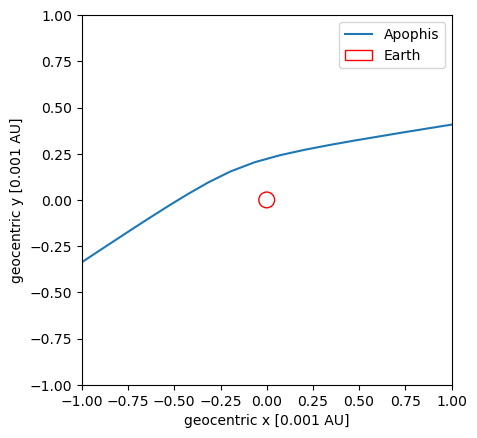

In [21]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("geocentric x [0.001 AU]"); ax.set_ylabel("geocentric y [0.001 AU]")
ax.set_xlim([-1,1]); ax.set_ylim([-1,1])
ax.plot((apophis_pos[:,0]-earth_pos[:,0])*1e3,(apophis_pos[:,1]-earth_pos[:,1])*1e3, label="Apophis")
c = plt.Circle((0,0),4.2587571e-02, edgecolor="r", facecolor='None', label="Earth")
ax.add_patch(c)
ax.legend();

In [42]:
t_initial = 2462137.5 - ephem.jd_ref # Julian Days relative to jd_ref

apophis_initial_helio = rebound.Particle(x = -5.450770368702937E-01, # AU 
                                         y =  8.625884531011220E-01, 
                                         z =  3.067841508125688E-01,
                                         vx= -1.395794822904029E-02, # AU/day
                                         vy= -5.791529394125580E-03, 
                                         vz= -2.503280483635055E-03)

# convert from heliocentric to barycentric coordinates
apophis_initial = apophis_initial_helio + sun_initial 



In [74]:
ex.detach(sim)
del(sim)

sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = t_initial 
sim.dt = 1.0
sim.ri_ias15.min_dt = 0.001
ex = assist.Extras(sim, ephem)
ex.particle_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.0])


res = []
with open('apophis_sb_daily_v2.txt') as file:
    file.readline()
    file.readline()
    file.readline()
    for i, line in enumerate(file):
        if i>10:
            break
        trange = float(line.split()[0])
        vec = np.array(line.rstrip().split()[-3:], dtype=np.double)
        
        t_target =t_initial + trange
        ex.integrate_or_interpolate(t_target)
        
        apophis = sim.particles[0]
        print(sim.t, apophis)

        sun = ephem.get_particle("sun", t_target)
        apophis_sb=vec/au_km + np.array([sun.x, sun.y, sun.z])
        diff = np.linalg.norm(apophis.xyz - apophis_sb)*au2m
        print(t_target, trange, diff)


10593.500480923769 <rebound.particle.Particle object at 0x18b5b5240, m=5.414019654588077e+241 x=471916.1021040805 y=-112115.10109866974 z=-387855.370910123 vx=471972.6033985094 vy=-112128.70620984068 vz=-387901.47955683555>
10593.5 1.0 9.29082686679478e+16
10594.500480923973 <rebound.particle.Particle object at 0x18b5b4e40, m=5.414019654588077e+241 x=943888.705377019 y=-224243.807365942 z=-775756.8502940173 vx=471972.6033505725 vy=-112128.70634064543 vz=-387901.47940381133>
10594.5 2.0 1.8582752147955658e+17
10595.508143601663 <rebound.particle.Particle object at 0x18b5b7ac0, m=5.414019654588077e+241 x=1415861.3087266588 y=-336372.5137064 z=-1163658.3296970348 vx=471972.6033505648 vy=-112128.70634067777 vz=-387901.4794037777>
10595.5 3.0 2.7874677427548896e+17
10596.542604575034 <rebound.particle.Particle object at 0x18b5b5040, m=5.414019654588077e+241 x=1887833.9120780362 y=-448501.2200472708 z=-1551559.8091014803 vx=471972.60335056664 vy=-112128.70634067821 vz=-387901.4794037792>
105

In [70]:
sim.particles[0]

<rebound.particle.Particle object at 0x18b5b5ec0, m=0.0 x=5191642.135123138 y=-1233402.1644143711 z=-4266870.164526151 vx=471972.60334292374 vy=-112128.70635653174 vz=-387901.47938291624>